In [1]:
#| include: false

import duckdb
import pandas as pd
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# %sql duckdb:///:memory:
conn = duckdb.connect()
%sql conn --alias duckdb-native

%sql CREATE OR REPLACE TABLE user_actions AS SELECT * FROM read_csv('00_data/sql/user_actions.csv', header=True, columns={'user_id': 'INT', 'order_id': 'INT', 'action': 'VARCHAR', 'time': 'TIMESTAMP'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE courier_actions AS SELECT * FROM read_csv('00_data/sql/courier_actions.csv', header=True, columns={'courier_id': 'INT', 'order_id': 'INT', 'action': 'VARCHAR', 'time': 'TIMESTAMP'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE orders AS SELECT * FROM read_csv('00_data/sql/orders.csv', header=True, columns={'order_id': 'INT', 'creation_time': 'TIMESTAMP', 'product_ids': 'INT[]'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE users AS SELECT * FROM read_csv('00_data/sql/users.csv', header=True, columns={'user_id': 'INT', 'birth_date': 'DATE', 'sex': 'VARCHAR'}, dateformat='%d/%m/%y');
%sql CREATE OR REPLACE TABLE couriers AS SELECT * FROM read_csv('00_data/sql/couriers.csv', header=True, columns={'courier_id': 'INT', 'birth_date': 'DATE', 'sex': 'VARCHAR'}, dateformat='%d/%m/%y');
%sql CREATE OR REPLACE TABLE products AS SELECT * FROM read_csv('00_data/sql/products.csv', header=True, columns={'product_id': 'INT', 'name': 'VARCHAR', 'price': 'DOUBLE'});

,Count
0,87


# Об'єднання таблиць

## Основні типи об'єднань JOIN

Ось ми й підібралися до однієї з найважливіших тем у SQL – об'єднання таблиць.

SQL-запити дозволяють вибирати та обробляти дані не тільки з однієї таблиці – у цьому ми вже переконалися, коли працювали з підзапитами. Але таблиці можна об'єднувати в один результуючий набір записів, пов'язуючи їх за певними умовами. Це дозволяє робити операція з'єднання `JOIN`.

Ми розглянемо такі типи з'єднань таблиць:

1. `INNER JOIN`
2. `LEFT/RIGHT JOIN`
3. `FULL JOIN`
4. `CROSS JOIN`

Оператори об'єднання включаються до розділу `FROM` запиту. Загалом, незалежно від того, який тип об'єднання використовується, запит на об'єднання таблиць виглядає наступним чином:

```sql
SELECT ...
FROM table_1 
     JOIN table_2
     ON [condition]
```

Як правило (але далеко не завжди), в якості умови **[condition]**, за якою відбувається об'єднання, виступає рівність значень у певних стовпцях. Такі стовпці зазвичай використовуються як ключі із зазначенням id (товару, користувача тощо), тобто значень, за якими можна однозначно ідентифікувати певну сутність:

```sql
SELECT table_1.column_1, table_2.column_2
FROM table_1 
     JOIN table_2
     ON table_1.id = table_2.id
```

При цьому рекомендується до кожної колонка через точку вказувати ім'я таблиці, яка містить цю колонку. Більше того, це стає вже не рекомендацією, а необхідністю, коли імена стовпців у таблицях збігаються - без явного вказівки джерел, база даних не зможе сама визначити, які стовпці та з яких таблиць ви маєте на увазі, і в результаті поверне помилку.

Якщо імена таблиць надто довгі, таблицям можна присвоїти аліаси. За цими ж аліасами можна відразу зручно звертатися до колонок:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     JOIN table_2 b
     ON a.id = b.id
```

Якщо ім'я поля, за котрим відбувається об'єднання, збігається в обох таблицях (як у прикладах вище), можна використовувати скорочений запис з оператором `USING`:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     JOIN table_2 b
     USING (id)
```

При об'єднанні таблиць можна використовувати підзапити. Їх можна поєднувати з іншими таблицями або одину з одною:

```sql
SELECT ...
FROM table_1
     JOIN (
          SELECT ...
          FROM table_2
     ) AS subquery
    ON table_1.id = subquery.id
...


SELECT ...
FROM (
     SELECT ...
     FROM table_1
) AS subquery_1
     JOIN (
          SELECT ...
          FROM table_2
     ) AS subquery_2
    ON subquery_1.id = subquery_2.id
...
```

## Як працює об'єднання таблиць

Добре, із записом у загальному вигляді начебто зрозуміло. Але що насправді відбувається при об'єднанні таблиць? Давайте розбиратися.

Процес об'єднання можна подати у вигляді наступної послідовності операцій:

1. Спочатку кожен рядок першої таблиці зіставляється з кожним рядком другої таблиці, тобто відбувається [декартів добуток](https://uk.wikipedia.org/wiki/%D0%94%D0%B5%D0%BA%D0%B0%D1%80%D1%82%D1%96%D0%B2_%D0%B4%D0%BE%D0%B1%D1%83%D1%82%D0%BE%D0%BA_%D0%BC%D0%BD%D0%BE%D0%B6%D0%B8%D0%BD) вдох множин, результатом якого є нове множина, що складається з різних пар вхідних рядків. Наприклад, якщо у одній таблиці було 50 записів, а інший 10, то результаті декартового добутку вийде 500 записів. На іграшковому прикладі це можна уявити так:

![Декартів добуток](img/sql/cartesian.png){#fig-cartesian width=45%}

2. Потім для кожного об'єднаного рядка, що складається з двох вхідних таблиць, перевіряється умова з'єднання, вказана після оператора `ON`.

3. Після цього відповідно до обраного типу об'єднання формується результуюча таблиця.

При з'єднанні yне двох, а кількох таблиць, операція об'єднання виконується послідовно кілька разів, тобто описаний вище алгоритм запускається стільки разів, скільки зазначено з'єднань. При цьому в цій послідовності при кожному об'єднанні можна використовувати будь-який тип з'єднання (`INNER`, `LEFT` тощо).

Для двох об'єднань запит може виглядати приблизно так:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     LEFT JOIN table_2 b
     ON a.user_id = b.user_id
     JOIN table_3 c
     ON b.order_id = c.order_id
...
```

Про те, як саме вибір типу `JOIN` впливає на результат, ми говоритимемо далі.

Якщо щось на цьому кроці залишилося незрозумілим, не переживайте. Далі все прояснимо на практичних прикладах!

## INNER JOIN

Перший тип об'єднання, який ми розглянемо, має назву `INNER JOIN`. Це оператор внутрішнього об'єднання, якому абсолютно неважливий порядок зазначення таблиць, тобто у таких випадках результат об'єднання буде однаковим:

```sql
SELECT ...
FROM table_1 INNER JOIN table_2
     ON [condition]
...


SELECT ...
FROM table_2 INNER JOIN table_1 
     ON [condition]
...
```

При цьому в запиті замість `INNER JOIN` можна писати просто `JOIN` - це те саме.

Результат об'єднання `INNER JOIN` формується так:

1. Спочатку кожен рядок першої таблиці зіставляється з кожним рядком другої таблиці (відбувається декартів добуток).
2. Потім для кожного об'єднаного рядка перевіряється умова з'єднання, вказана після оператора `ON`.
3. Після цього всі об'єднані рядки, для яких умова виявилася істинною, додаються до результуючої таблиці.

Таким чином, в результаті об'єднання `INNER JOIN` із двох таблиць відкидаються усі рядки, які не пройшли перевірку на відповідність зазначеній умові. От і все!

Розглянемо наступний приклад:

```sql
SELECT A.id as id,
       A.city as city,
       B.country as country
FROM table_A as A
     JOIN table_B as B
     ON A.id = B.id
```
В результаті такого запиту таблиці `table_A` та `table_B` будуть об'єднані в таблицю `table_С`:

::: {#tbl-panel layout="[[1,1], [1]]"}

| id   | city    |
|------|---------|
| 01    | London |
| 02    | Kyiv   |

: Таблиця A {#tbl-A .sm .primary .bordered}

| id    | country  |
|-------|----------|
| 02    | Ukraine  |
| 03    |  Poland  |

: Таблиця B {#tbl-B .sm .secondary .bordered}

| id    | city     | country  |
|-------|----------|----------|
| 02    | Kyiv     | Ukraine  |

: Таблиця C {#tbl-C .sm .success .bordered}

Приклад роботи `INNER JOIN`
:::

Оскільки таблиці збігаються лише за одним значенням у стовпці `id`, то в результат буде включено лише одне запис.

Схематично результат роботи об'єднань прийнято зображувати за допомогою [діаграм Венна](https://uk.wikipedia.org/wiki/%D0%94%D1%96%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%B0_%D0%92%D0%B5%D0%BD%D0%BD%D0%B0). Для `INNER JOIN` наведено на [рисунку @fig-sql-inner-join].

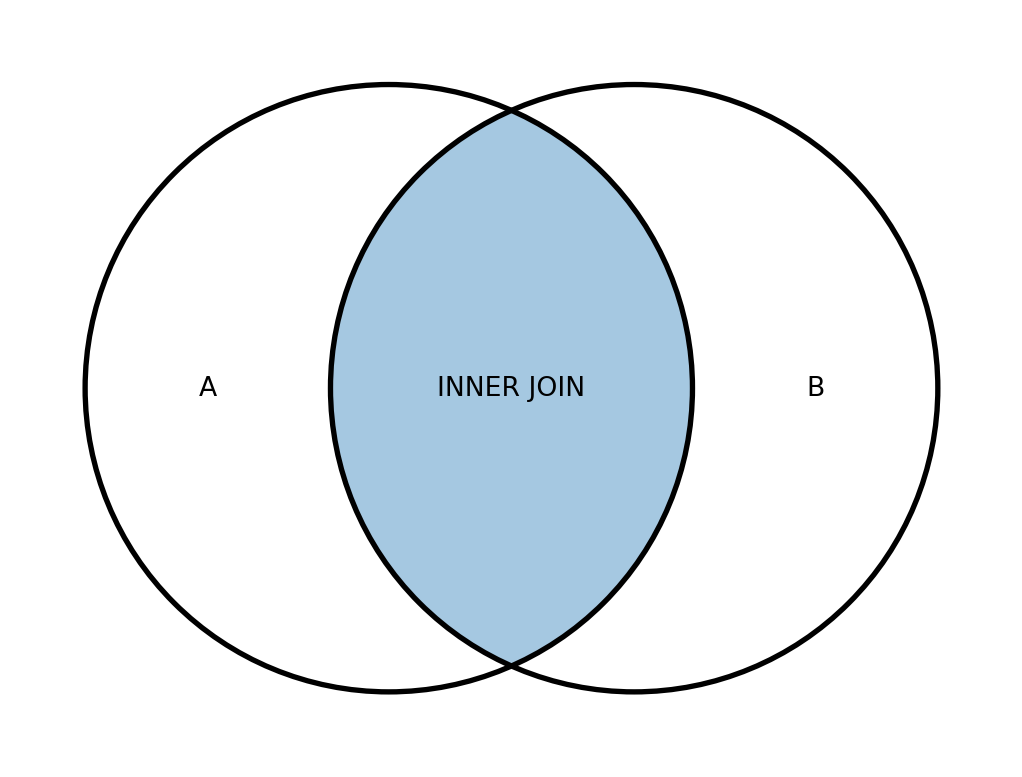

In [2]:
# | echo: false
# | label: fig-sql-inner-join
# | fig-cap: "Діаграма Венна: INNER JOIN"

from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
v.get_patch_by_id("10").set_alpha(1.0)
v.get_patch_by_id("10").set_color("white")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_alpha(1.0)
v.get_patch_by_id("01").set_color("white")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("INNER JOIN")
v.get_patch_by_id("11").set_color("tab:blue")

::: {.callout-note}
Докладніше про `INNER JOIN` можна почитати [тут](https://duckdb.org/docs/sql/query_syntax/from#outer-joins).
:::

А тепер давайте повернемося до нашої бази даних та вирішимо завдання.

Для початку спробуйте виконати наступні два запити та порахувати кількість унікальних користувачів у таблицях `users` та `user_actions`:

In [3]:
%%sql
SELECT COUNT(DISTINCT user_id) AS users_count
FROM users

,users_count
0,20331


In [4]:
%%sql
SELECT COUNT(DISTINCT user_id) as users_count
FROM user_actions

,users_count
0,21401


Ви помітите, що у таблиці `user_actions` унікальних користувачів більше. Це означає, що про частину користувачів ми щось не знаємо — у нас просто немає інформації в таблиці `users`. Тому в результаті об'єднання цих двох таблиць за допомогою `INNER JOIN` цю частину користувачів буде виключено з результату.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-01}
<br>
Об'єднайте таблиці `user_actions` та `users` за ключом `user_id`. У результаті включіть дві колонки з `user_id` з обох таблиць. Ці дві колонки назвіть відповідно `user_id_left` та `user_id_right`. Також у результат включіть колонки `order_id`, `time`, `action`, `sex`, `birth_date`. Відсортуйте таблицю за зростанням id користувача (у будь-якій з двох колонок з id).

Поля в результуючій таблиці: `user_id_left`, `user_id_right`, `order_id`, `time`, `action`, `sex`, `birth_date`

:::

::::

::: {.callout-note}
Зверніть увагу, що в результаті об'єднання колонки з ключами (у нашому випадку це `user_id`) не перетворюються на одну загальну колонку, а разом додаються в результуючу таблицю. Тобто скільки було сумарно колонок у двох таблицях, стільки виявиться і в результуючій таблиці після об'єднання. А вже далі в операторі `SELECT` можна вибирати потрібні та проводити над ними операції.

Щоб звернутися до колонок з однаковим ім'ям (`user_id`), що прийшли з різних таблиць, призначте таблицям аліаси та зверніться до колонок через них. Приклад, як це можна зробити:

```sql
SELECT A.id as id_a, 
       B.id as id_b, 
       ...
FROM table_A as A
     JOIN table_B as B
     ON A.id = B.id
...
```
:::

In [5]:
#| code-fold: true
#| code-summary: "Рішення"
#| column: body-outset

%%sql
SELECT a.user_id as user_id_left,
       b.user_id as user_id_right,
       order_id,
       time,
       action,
       sex,
       birth_date
FROM   user_actions a join users b using (user_id)
ORDER BY user_id_left

,user_id_left,user_id_right,order_id,time,action,sex,birth_date
0,1,1,1,2022-08-24 01:52:00,create_order,female,1991-10-23
1,1,1,4683,2022-08-27 20:56:00,create_order,female,1991-10-23
2,1,1,22901,2022-09-02 00:58:00,create_order,female,1991-10-23
3,1,1,23149,2022-09-02 02:36:00,create_order,female,1991-10-23
4,2,2,2,2022-08-24 06:37:00,create_order,female,1993-06-18
...,...,...,...,...,...,...,...
59341,21399,21399,59583,2022-09-08 23:56:00,create_order,female,1987-04-27
59342,21399,21399,59587,2022-09-08 23:58:00,create_order,female,1987-04-27
59343,21400,21400,59586,2022-09-08 23:57:00,create_order,male,1986-12-31
59344,21401,21401,59589,2022-09-08 23:58:00,create_order,female,1993-03-20


---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-02}
<br>
А тепер спробуйте трохи переписати запит із минулого завдання та порахувати кількість унікальних id в об'єднаній таблиці. Тобто знову поєднайте таблиці, але цього разу просто порахуйте унікальні `user_id` в одній з колонок з id. Виведіть цю кількість як результат. Назвіть колонку з порахованим значенням `users_count`.

Поле у результуючій таблиці: `users_count`

Після того, як вирішите завдання, порівняйте отримане значення з кількістю унікальних користувачів у таблицях `users` та `user_actions`, яку ми порахували раніше. З яким значенням воно збігається?

:::

::::

In [6]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT count(distinct a.user_id) as users_count
FROM   user_actions a 
    JOIN users b using (user_id)

,users_count
0,20331


---

## LEFT та RIGHT JOIN

Наступний тип об'єднання, який ми розглянемо, це `LEFT OUTER JOIN` (або просто `LEFT JOIN`).

`LEFT JOIN `— це оператор зовнішнього об'єднання, котрій важливий порядок таблиць у запиті, тобто на відміну від `INNER JOIN`, він не є симетричним.

Тому наступні два записи вже не є еквівалентними:

```sql
SELECT ...
FROM table_1 LEFT JOIN table_2
     ON [condition]
...


SELECT ...
FROM table_2 LEFT JOIN table_1 
     ON [condition]
...
```

Результат об'єднання `LEFT JOIN` формується так:

1. Спочатку кожен рядок лівої таблиці зіставляється з кожним рядком правої таблиці (відбувається декартів добуток).
2. Потім для кожного об'єднаного рядка перевіряється умова з'єднання, вказана після оператора `ON`.
3. Після цього всі об'єднані рядки, для яких умова виявилася істинною, додаються до результуючої таблиці.
4. Далі в результат додаються ті записи з лівої таблиці (**увага: тільки з лівої**), для яких умова виявилася хибною і які не увійшли до об'єднання на попередньому кроці. При цьому для таких записів відповідні поля правої таблиці заповнюються значеннями `NULL`.

Якщо уважно подивитися на описаний алгоритм, можна зрозуміти, що він легко зводиться до наступної послідовності дій:

- Спочатку відповідно до зазначеної умови виконується `INNER JOIN` першої та другої таблиць.
- Потім до результату додаються ті записи з лівої таблиці (**увага: тільки з лівої**), для яких умова виявилася хибною і які не увійшли до об'єднання на попередньому кроці. При цьому для таких записів відповідні поля правої таблиці заповнюються значеннями `NULL`.

Ось і вся магія!

Об'єднання `RIGHT JOIN` працює аналогічним чином, тільки на другому етапі результат `INNER JOIN` додаються записи не з лівої, а **з правої таблиці**.

Давайте знову розглянемо кілька простих прикладів.

Так буде виглядати запит та його результат із `LEFT JOIN`:

```sql
SELECT A.id as id,
       A.city as city,
       B.country as country
FROM table_A as A
     LEFT JOIN table_B as B
     ON A.id = B.id
```

::: {#tbl-panel layout="[[1,1], [1]]"}

| id   | city    |
|------|---------|
| 01    | London |
| 02    | Kyiv   |

: Таблиця A {#tbl-A-left .sm .primary .bordered}

| id    | country  |
|-------|----------|
| 02    | Ukraine  |
| 03    |  Poland  |

: Таблиця B {#tbl-B-left .sm .secondary .bordered}

| id    | city     | country  |
|-------|----------|----------|
| 01    | London   | NULL     |
| 02    | Kyiv     | Ukraine  |

: Таблиця C {#tbl-C-left .sm .success .bordered}

Приклад роботи `LEFT JOIN`
:::

У цьому випадку до результату потрапить запис з `id 2`, оскільки вона є в обох таблицях, а також запис з `id 1` з лівої таблиці.

Діаграма Венна для `LEFT JOIN` наведено на [рис. @fig-sql_left-join].

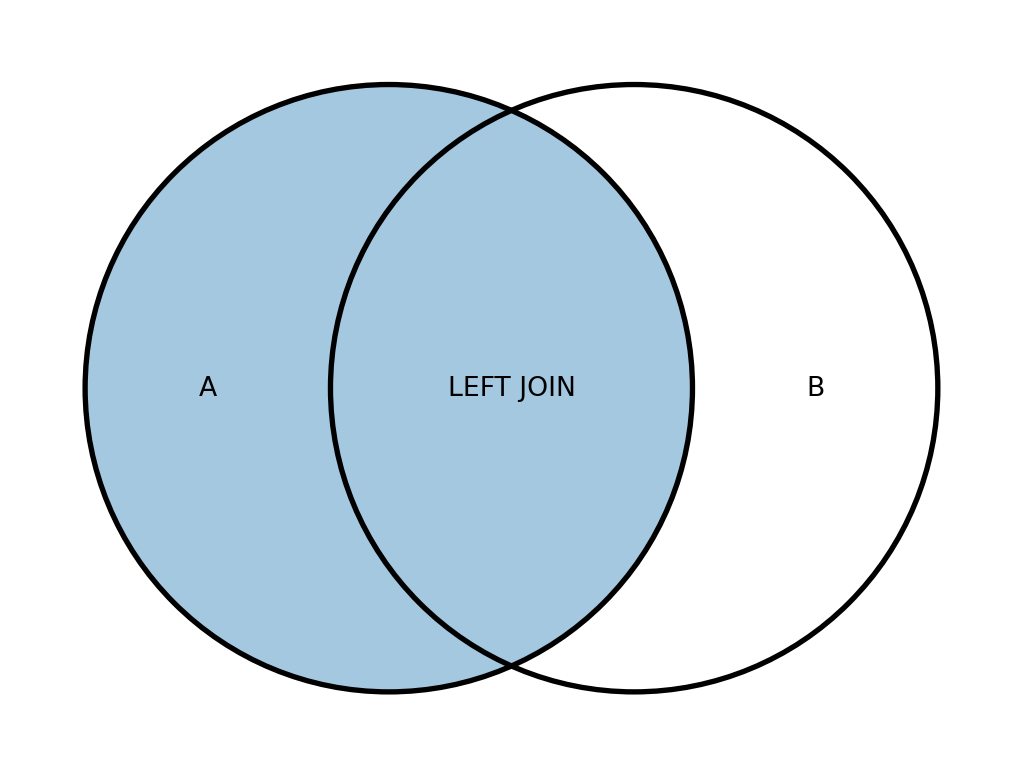

In [7]:
# | echo: false
# | label: fig-sql_left-join
# | fig-cap: "Діаграма Венна: LEFT JOIN"

from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
# v.get_patch_by_id("10").set_alpha(1.0)
v.get_patch_by_id("10").set_color("tab:blue")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_alpha(1.0)
v.get_patch_by_id("01").set_color("white")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("LEFT JOIN")
v.get_patch_by_id("11").set_color("tab:blue")

А ось таким вийде результат запиту з `RIGHT JOIN`:

```sql
SELECT B.id as id,
       A.city as city,
       B.country as country
FROM table_A as A
     RIGHT JOIN table_B as B
     ON A.id = B.id
```

::: {#tbl-panel layout="[[1,1], [1]]"}

| id   | city    |
|------|---------|
| 01    | London |
| 02    | Kyiv   |

: Таблиця A {#tbl-A-right .sm .primary .bordered}

| id    | country  |
|-------|----------|
| 02    | Ukraine  |
| 03    |  Poland  |

: Таблиця B {#tbl-B-right .sm .secondary .bordered}

| id    | city     | country  |
|-------|----------|----------|
| 02    | Kyiv     | Ukraine  |
| 03    | NULL     | Poland   |

: Таблиця C {#tbl-C-right .sm .success .bordered}

Приклад роботи `RIGHT JOIN`
:::

Все як і у випадку з `LEFT JOIN`, тільки в результат вже потрапить запис з `id 3` з правої таблиці.

Діаграма Венна для `RIGHT JOIN` зображена на [рис. @fig-sql_right-join]

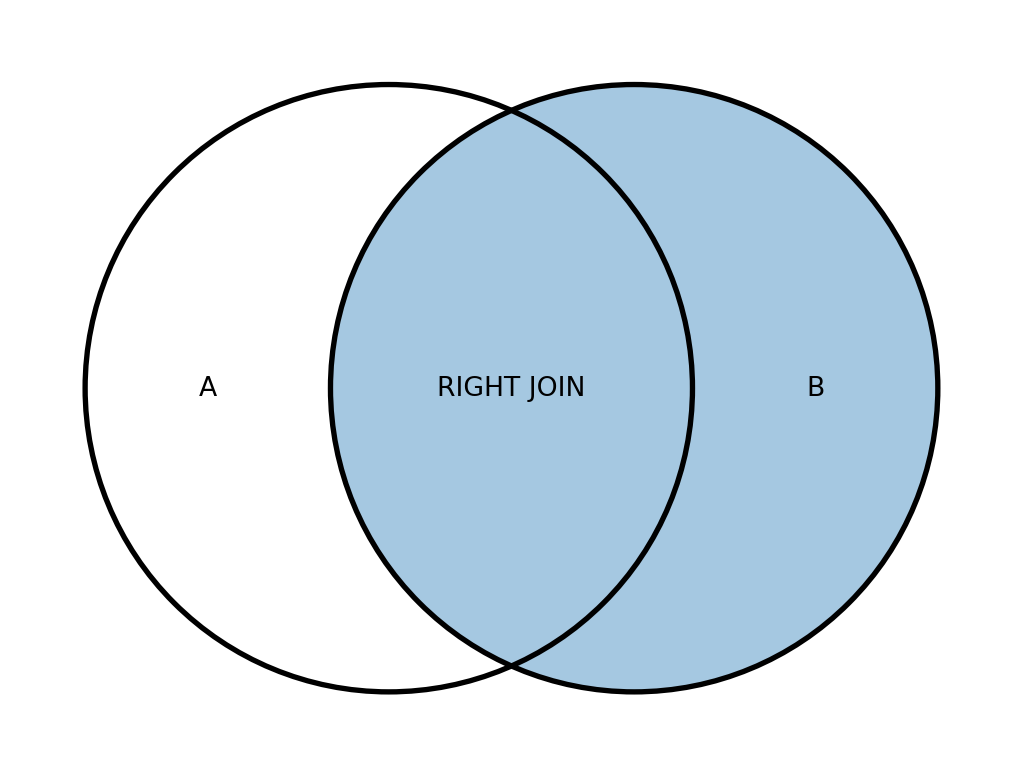

In [8]:
# | echo: false
# | label: fig-sql_right-join
# | fig-cap: "Діаграма Венна: LEFT JOIN"

from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
# v.get_patch_by_id("10").set_alpha(1.0)
v.get_patch_by_id("10").set_color("white")
v.get_label_by_id("10").set_text("A")
# v.get_patch_by_id("01").set_alpha(1.0)
v.get_patch_by_id("01").set_color("tab:blue")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("RIGHT JOIN")
v.get_patch_by_id("11").set_color("tab:blue")

А тепер розглянемо на прикладі наших даних.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-03}
<br>
За допомогою `LEFT JOIN` об'єднайте таблиці `user_actions` та `users` за ключом `user_id`. Зверніть увагу на порядок таблиць – ліворуч `users_actions`, праворуч `users`. У результаті включіть дві колонки з `user_id` з обох таблиць. Ці дві колонки назвіть відповідно `user_id_left` та `user_id_right`. Також у результат увімкніть колонки `order_id`, `time`, `action`, `sex`, `birth_date`. Відсортуйте таблицю, що вийшла, за зростанням id користувача (у колонці з **лівої** таблиці).

Поля в результуючій таблиці: `user_id_left`, `user_id_right`, `order_id`, `time`, `action`, `sex`, `birth_date`

Після того як розв'яжете завдання, зверніть увагу на колонки з `user_id`. Чи немає в якомусь із них пропущених значень?
:::

::::

In [9]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT a.user_id as user_id_left,
       b.user_id as user_id_right,
       order_id,
       time,
       action,
       sex,
       birth_date
FROM   user_actions a
    LEFT JOIN users b using (user_id)
ORDER BY user_id_left

,user_id_left,user_id_right,order_id,time,action,sex,birth_date
0,1,1.0,1,2022-08-24 01:52:00,create_order,female,1991-10-23
1,1,1.0,4683,2022-08-27 20:56:00,create_order,female,1991-10-23
2,1,1.0,22901,2022-09-02 00:58:00,create_order,female,1991-10-23
3,1,1.0,23149,2022-09-02 02:36:00,create_order,female,1991-10-23
4,2,2.0,2,2022-08-24 06:37:00,create_order,female,1993-06-18
...,...,...,...,...,...,...,...
62569,21399,21399.0,59583,2022-09-08 23:56:00,create_order,female,1987-04-27
62570,21399,21399.0,59587,2022-09-08 23:58:00,create_order,female,1987-04-27
62571,21400,21400.0,59586,2022-09-08 23:57:00,create_order,male,1986-12-31
62572,21401,21401.0,59589,2022-09-08 23:58:00,create_order,female,1993-03-20


---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-04}
<br>
Тепер знову спробуйте трохи переписати запит з минулого завдання та порахуйте кількість унікальних id у колонці `user_id`, що надійшла з лівої таблиці `user_actions`. Виведіть цю кількість як результат. Назвіть колонку з порахованим значенням `users_count`.

Поле у результуючій таблиці: `users_count`

Після того, як вирішите завдання, порівняйте отримане значення з кількістю унікальних користувачів у таблицях `users` та `user_actions`. З яким значенням воно збіглося цього разу?
:::

::::

In [10]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT count(distinct a.user_id) as users_count
FROM   user_actions a
    LEFT JOIN users b using (user_id)

,users_count
0,21401


---

Ви могли помітити, що при об'єднанні таблиць `user_actions` і `users` за допомогою `LEFT JOIN` у стовпцях, що прийшли з правої таблиці `users`, утворилися значення `NULL`. Якщо не помітили, спробуйте відсортувати об'єднану таблицю по полях `users.user_id` і `users.birth_date`.

Це саме те, про що ми говорили — при формуванні об'єднаних рядків для тих id з лівої таблиці, яких не було в правій таблиці, поля з правої таблиці були заповнені порожніми значеннями.

А тепер давайте перевернемо один трюк.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-05}
<br>
Візьміть запит із [завдання @exr-sql-join-03], де ви об'єднували таблиці `user_actions` і `users` за допомогою `LEFT JOIN`, додайте до запиту оператор `WHERE` і виключіть значення `NULL` в колонці `user_id` з правої таблиці. Включіть у результат ті самі колонки і відсортуйте таблицю, що вийшла, за зростанням id користувача в колонці з лівої таблиці.

Поля в результуючій таблиці: `user_id_left`, `user_id_right`, `order_id`, `time`, `action`, `sex`, `birth_date`

Після того як розв'яжете завдання, спробуйте порівняти це рішення із [завданням @exr-sql-join-01]. Подумайте, який `JOIN` ми отримали після всіх маніпуляцій з результатом. Заодно можете порахувати кількість унікальних `user_id` у запиті з цього завдання, щоб розставити всі крапки над "i".
:::

::::

In [11]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT a.user_id as user_id_left,
       b.user_id as user_id_right,
       order_id,
       time,
       action,
       sex,
       birth_date
FROM   user_actions a
    LEFT JOIN users b using (user_id)
WHERE  b.user_id IS NOT NULL
ORDER BY user_id_left

,user_id_left,user_id_right,order_id,time,action,sex,birth_date
0,1,1,1,2022-08-24 01:52:00,create_order,female,1991-10-23
1,1,1,4683,2022-08-27 20:56:00,create_order,female,1991-10-23
2,1,1,22901,2022-09-02 00:58:00,create_order,female,1991-10-23
3,1,1,23149,2022-09-02 02:36:00,create_order,female,1991-10-23
4,2,2,2,2022-08-24 06:37:00,create_order,female,1993-06-18
...,...,...,...,...,...,...,...
59341,21399,21399,59583,2022-09-08 23:56:00,create_order,female,1987-04-27
59342,21399,21399,59587,2022-09-08 23:58:00,create_order,female,1987-04-27
59343,21400,21400,59586,2022-09-08 23:57:00,create_order,male,1986-12-31
59344,21401,21401,59589,2022-09-08 23:58:00,create_order,female,1993-03-20


---

## FULL JOIN

Щоб краще розібратися з джойнами, розглянемо ще один тип об'єднання таблиць — `FULL OUTER JOIN` або просто `FULL JOIN`. Це оператор повного зовнішнього об'єднання, для якого, як і `INNER JOIN`, неважливий порядок вказівки таблиць. Проте працює він зовсім інакше.

Запит із `FULL OUTER JOIN` виглядає приблизно так:

```sql
SELECT ...
FROM table_1 FULL JOIN table_2
     ON [condition]
...


SELECT ...
FROM table_2 FULL JOIN table_1 
     ON [condition]
...
```

Результат об'єднання `FULL JOIN` формується так:

1. Спочатку кожен рядок лівої таблиці зіставляється з кожним рядком правої таблиці (відбувається декартів добуток).
2. Потім для кожного об'єднаного рядка перевіряється умова об'єднання, вказана після оператора `ON`.
3. Після цього всі об'єднані рядки, для яких умова виявилася істинною, додаються до результуючої таблиці.
4. Далі в результат додаються ті записи з лівої та правої таблиць (**увага: з обох таблиць**), для яких умова виявилася хибною і які не увійшли до об'єднання на попередньому кроці. При цьому для таких записів відповідні поля з іншої таблиці (для лівої це поля з правої, для правої це поля з лівої) заповнюються значеннями `NULL`.

Цей алгоритм можна звести до наступної послідовності дій:

- Спочатку відповідно до зазначеної умови виконується `INNER JOIN` лівої та правої таблиць.
- Далі в результат додаються ті записи з лівої та правої таблиць (**увага: з обох таблиць**), для яких умова виявилася хибною і які не увійшли до об'єднання на попередньому кроці. При цьому для таких записів відповідні поля з іншої таблиці (для лівої це поля з правої, для правої це поля з лівої) заповнюються значеннями `NULL`.

Розглянемо найпростіший приклад.

Так буде виглядати запит та його результат з FULL JOIN:

```sql
SELECT A.id as id,
       A.city as city,
       B.country as country
FROM table_A as A
     FULL JOIN table_B as B
     ON A.id = B.id
```

::: {#tbl-panel layout="[[1,1], [1]]"}

| id   | city    |
|------|---------|
| 01    | London |
| 02    | Kyiv   |

: Таблиця A {#tbl-A-full .sm .primary .bordered}

| id    | country  |
|-------|----------|
| 02    | Ukraine  |
| 03    |  Poland  |

: Таблиця B {#tbl-B-full .sm .secondary .bordered}

| id    | city     | country  |
|-------|----------|----------|
| 01    | London   | NULL     |
| 02    | Kyiv     | Ukraine  |
| 03    | NULL     | Poland   |

: Таблиця C {#tbl-C-full .sm .success .bordered}

Приклад роботи `FULL JOIN`
:::

В результат потрапив спільний запис з `id 2`, а також всі записи, до яких не було знайдено відповідності з інших таблиць. Усі невідповідності були заповнені порожніми значеннями.

Діграма Венна для `FULL JOIN` наведено на [рисунку @fig-sql-join-full-venn].

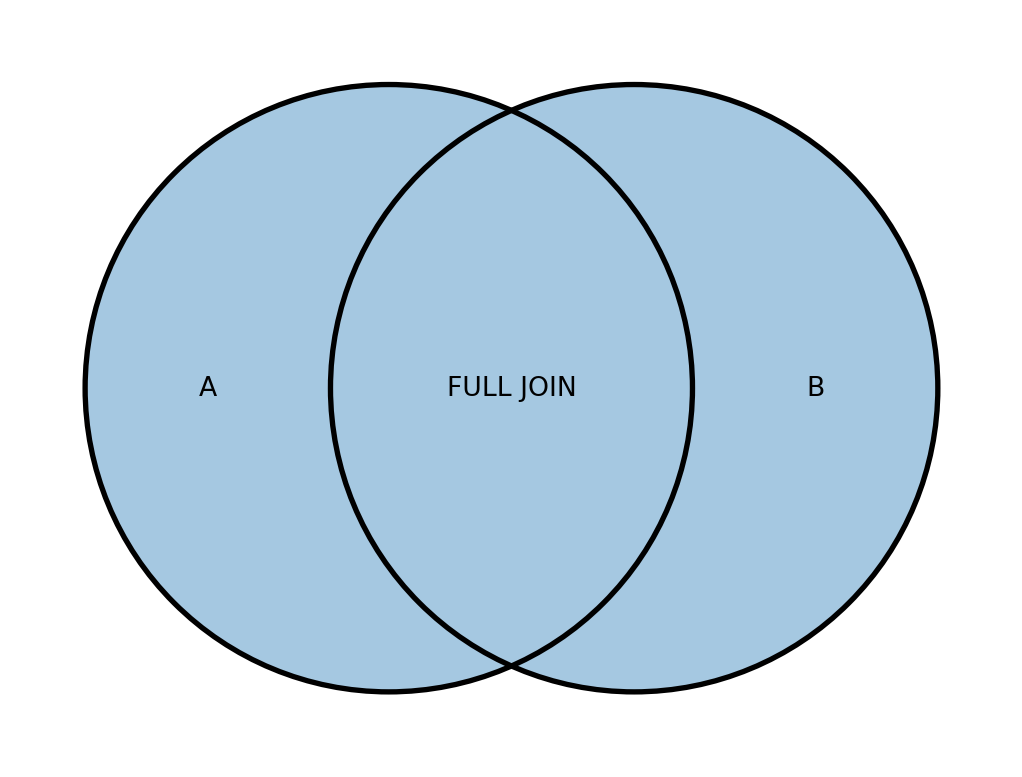

In [12]:
# | echo: false
# | label: fig-sql-join-full-venn
# | fig-cap: "Діаграма Венна: FULL JOIN"

from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
# v.get_patch_by_id("10").set_alpha(1.0)
v.get_patch_by_id("10").set_color("tab:blue")
v.get_label_by_id("10").set_text("A")
# v.get_patch_by_id("01").set_alpha(1.0)
v.get_patch_by_id("01").set_color("tab:blue")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("FULL JOIN")
v.get_patch_by_id("11").set_color("tab:blue")

А тепер розберемося з `FULL JOIN` на прикладі нашої бази даних.

У нас є дві таблиці з датами народження користувачів та кур'єрів – `users` та `couriers`. Можна припустити, що в кожній таблиці у колонці `birth_date` є якісь дати, яких немає в іншій таблиці. Тобто такі дати, в які народився хтось із кур'єрів, але не народився жоден користувач, і навпаки. Ну що ж, спробуємо перевірити цю гіпотезу.

Для початку згрупуємо дві таблиці по колонці `birth_date` і порахуємо скільки користувачів/кур'єрів народилися в кожен з днів. Для цього можете виконати такий запит:

In [13]:
%%sql
SELECT birth_date, COUNT(user_id) AS users_count
FROM users
WHERE birth_date IS NOT NULL
GROUP BY birth_date

,birth_date,users_count
0,1991-05-24,11
1,1994-07-21,6
2,1992-01-09,13
3,1997-05-05,3
4,1990-08-16,5
...,...,...
4471,1999-12-01,1
4472,1998-12-05,1
4473,1987-09-24,1
4474,1998-01-02,1


In [14]:
%%sql
SELECT birth_date, COUNT(courier_id) AS couriers_count
FROM couriers
WHERE birth_date IS NOT NULL
GROUP BY birth_date

,birth_date,couriers_count
0,1981-06-11,1
1,1991-06-27,2
2,1994-05-04,2
3,1999-06-02,2
4,1998-12-22,2
...,...,...
2169,1999-09-19,1
2170,1990-06-23,1
2171,1991-02-21,1
2172,1990-06-04,1


У результаті ви отримаєте дві таблиці з унікальними датами і кількістю людей, що народилися у кожен з днів. Давайте їх об'єднаємо.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-06}
<br>
За допомогою `FULL JOIN` об'єднайте по ключу `birth_date` таблиці, отримані в результаті вищезазначених запитів (тобто об'єднайте один з одним два підзапити). Не потрібно змінювати їх, просто додайте потрібний `JOIN`.

У результат включіть дві колонки з `birth_date` з обох таблиць. Ці дві колонки назвіть відповідно `users_birth_date` та `couriers_birth_date`. Також включіть у результат колонки з кількістю користувачів та кур'єрів - `users_count` та `couriers_count`.

Відсортуйте таблицю спочатку по колонці `users_birth_date` за зростанням, потім по колонці `couriers_birth_date` - теж за зростанням.

Поля в результуючій таблиці: `users_birth_date`, `users_count`, `couriers_birth_date`, `couriers_count`

Після того як розв'яжете завдання, проаналізуйте результат. Зверніть увагу на пропущені значення у колонках з датами народження кур'єрів та користувачів. Чи підтвердилося наше припущення?
:::

::::

In [15]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
WITH a AS (
    SELECT birth_date, COUNT(user_id) AS users_count
    FROM users
    WHERE birth_date IS NOT NULL
    GROUP BY birth_date
    ),
    b AS (
    SELECT birth_date, COUNT(courier_id) AS couriers_count
    FROM couriers
    WHERE birth_date IS NOT NULL
    GROUP BY birth_date
    )
    
SELECT 
    a.birth_date AS users_birth_date,
    a.users_count,
    b.birth_date AS couriers_birth_date,
    b.couriers_count
FROM a
FULL JOIN b on a.birth_date = b.birth_date
ORDER BY users_birth_date, couriers_birth_date

---

## Операції над множинами

Чудово. Запит із `FULL JOIN` ми начебто склали, але як нам тепер визначити, що кількість записів в отриманій таблиці збігається із загальним числом унікальних дат у двох таблицях — `users` та `couriers`? Адже саме стільки рядків ми й очікували отримати, правда?

Перевірити себе нам допоможуть операції з множинами. У мові SQL їх три:

- `UNION`
- `EXCEPT`
- `INTERSECT`

Вони дозволяють комбінувати результати кількох запитів один з одним та отримувати один загальний результат. Причому саме комбінувати, а не об'єднувати, як це роблять джойни.

Цю різницю важливо розуміти: в операціях з множинами не відбувається суміщення стовпців з двох таблиць - база даних просто відбирає рядки з таблиць, що задовольняють типу операції, і додає їх до загального результату.

Операції над множинами мають наступний синтаксис:

```sql
SELECT column_1, column_2
FROM table_1
UNION
SELECT column_1, column_2
FROM table_2


SELECT column_1, column_2
FROM table_1
EXCEPT
SELECT column_1, column_2
FROM table_2


SELECT column_1, column_2
FROM table_1
INTERSECT
SELECT column_1, column_2
FROM table_2
```

- Операція `EXCEPT` повертає всі записи, які є у першому запиті, але відсутні у другому (різниця множин).
- Операція `INTERSECT` повертає всі записи, які є і в першому, і в другому запиті (перетин множин).
- Операція `UNION` поєднує записи із двох запитів в один загальний результат (об'єднання множин).

При цьому за замовчанням ці операції виключають із результату рядки-дублікати. Щоб дублікати не виключалися із результату, необхідно після імені операції вказати ключове слово `ALL`. Наприклад, так:

```sql
SELECT column_1, column_2
FROM table_1
UNION ALL
SELECT column_1, column_2
FROM table_2
```

Діаграми Венна для операцій над множинами виглядають зображено на [рисунку @fig-sql-join-venn].

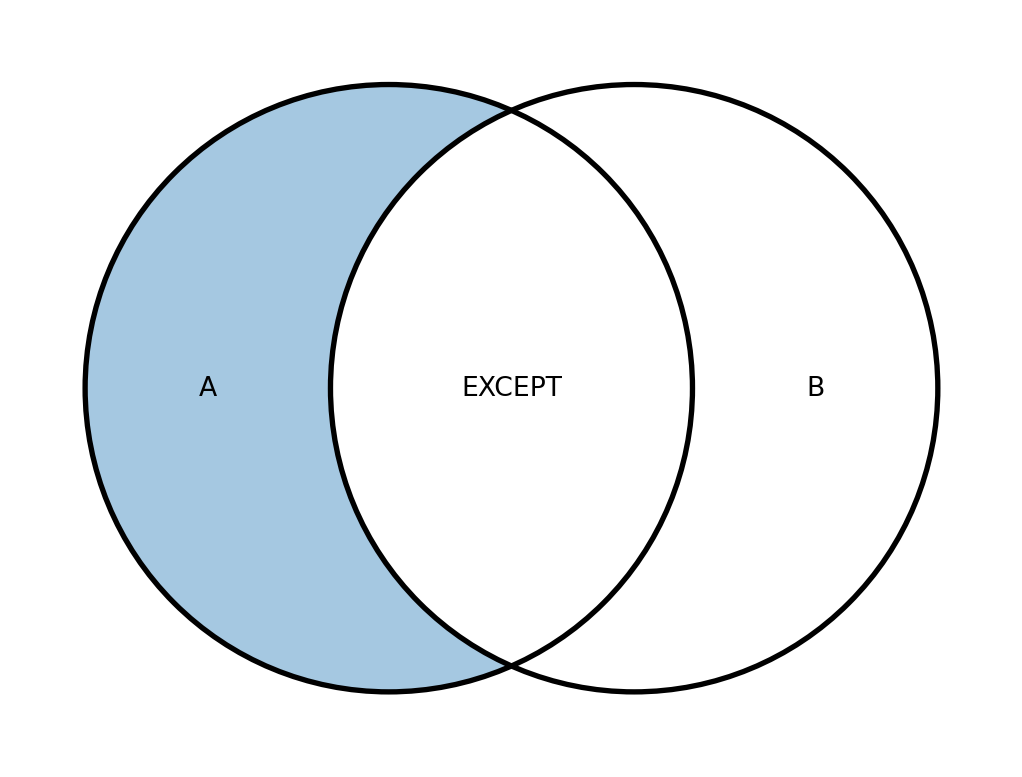

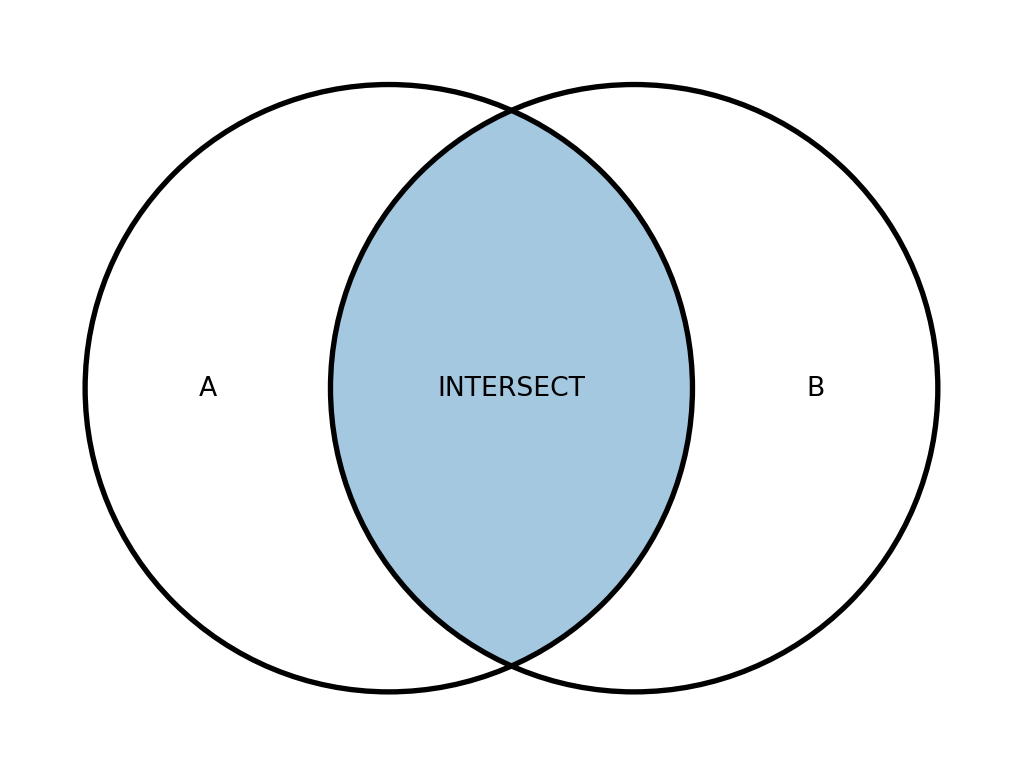

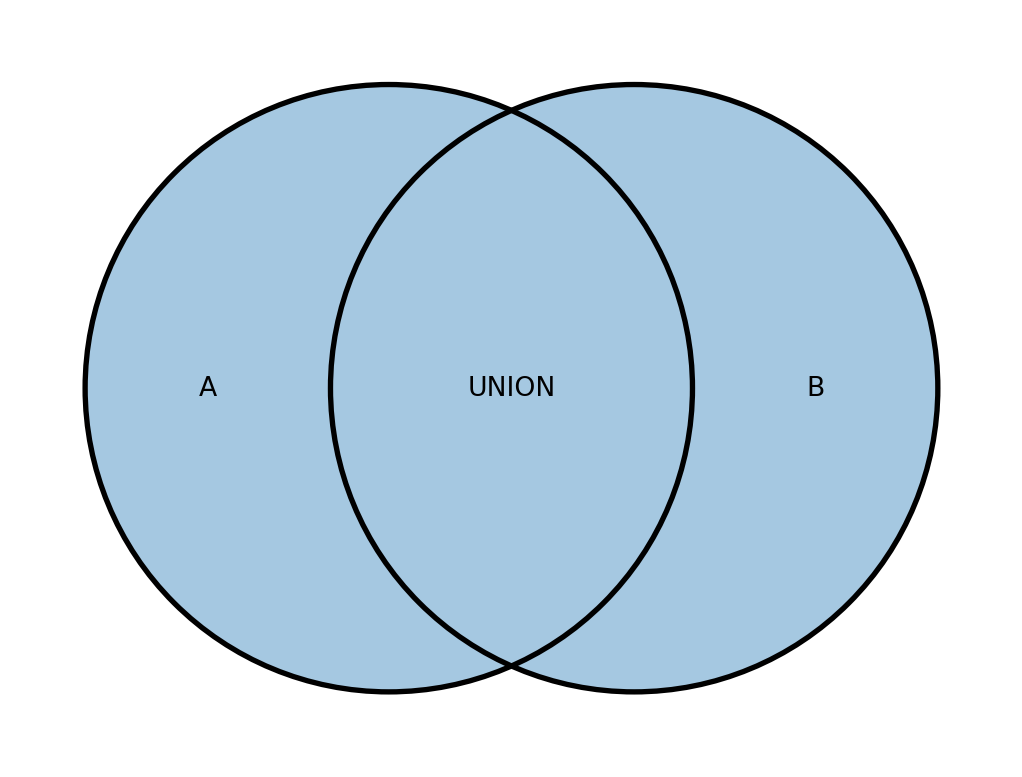

In [16]:
# | echo: false
# | label: fig-sql-join-venn
# | fig-cap: "Операції над множинами: діаграма Венна"
# | fig-subcap:
# |   - ""
# |   - ""
# |   - ""
# | layout-ncol: 3
# | column: page-inset

from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
v.get_patch_by_id("10").set_color("tab:blue")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_color("white")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("EXCEPT")
v.get_patch_by_id("11").set_color("white")
plt.show()

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
v.get_patch_by_id("10").set_color("white")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_color("white")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("INTERSECT")
v.get_patch_by_id("11").set_color("tab:blue")
plt.show()

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
v.get_patch_by_id("10").set_color("tab:blue")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_color("tab:blue")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("UNION")
v.get_patch_by_id("11").set_color("tab:blue")
plt.show()

Для роботи цих операцій необхідно, щоб виконувались такі умови:

1. У кожному запиті `SELECT` має бути однакова кількість стовпців.
2. Типи даних у стовпцях мають бути сумісні.

При цьому кількість стовпців в операторі `SELECT` може бути будь-якою — головне, щоб вона була однаковою.

Наприклад, наступний запит поверне унікальні ID користувачів, які щось замовляли в нашому сервісі, але яких з якоїсь причини немає в таблиці `users`:

In [17]:
%%sql
SELECT user_id
FROM user_actions
EXCEPT
SELECT user_id
FROM users

,user_id
0,54
1,86
2,103
3,116
4,120
...,...
1065,18352
1066,12713
1067,18246
1068,18015


::: {.callout-note}
Докладніше про операції над множинами можна прочитати у [документації DuckDB](https://duckdb.org/docs/sql/query_syntax/setops.html).

Про теорію множин можна почитати у [статті на Вікіпедії](https://uk.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D1%96%D1%8F_%D0%BC%D0%BD%D0%BE%D0%B6%D0%B8%D0%BD).
:::

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-07}
<br>
Поєднайте два наступні запити один з одним так, щоб на виході вийшов набір унікальних дат із таблиць `users` та `couriers`:

```sql
SELECT birth_date
FROM users
WHERE birth_date IS NOT NULL
```

```sql
SELECT birth_date
FROM couriers
WHERE birth_date IS NOT NULL
```

Помістіть у підзапит набраний після об'єднання набір дат і порахуйте їх кількість. Назвіть колонку з числом дат `dates_count`.

Поле у результуючій таблиці: `dates_count`

Після того, як вирішите задачу, порівняйте отримане число дат з кількістю рядків у таблиці, яку ми отримали в минулому завданні. Чи збіглися ці значення?
:::

::::

In [18]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
WITH sub_union as (
    SELECT birth_date
    FROM users
    WHERE birth_date IS NOT NULL
    UNION
    SELECT birth_date
    FROM couriers
    WHERE birth_date IS NOT NULL
    )
    
SELECT COUNT(DISTINCT birth_date) as dates_count
FROM sub_union

,dates_count


---

## CROSS JOIN

Насправді `CROSS JOIN` - це просто декартів добуток двох таблиць, тобто саме те, що відбувається на першому етапі решти джойнів. Важлива відмінність у синтаксисі `CROSS JOIN` полягає в тому, що для нього не потрібно вказувати умову для об'єднання:

```sql
SELECT column_1, column_2, ...
FROM table_1
     CROSS JOIN table_2
```

Той самий результат можна отримати за допомогою наступного запису:

```sql
SELECT column_1, column_2, ...
FROM table_1, table_2
```

Розглянемо простий приклад:

```sql
SELECT
    A.city as city,
    B.country as country
FROM table_A as A
     CROSS JOIN table_B as B
```

За допомогою `CROSS JOIN` ми отримуємо всі можливі комбінації значень із першої та другої таблиці:

::: {#tbl-panel layout="[[1,1], [1]]"}

| city    |
|---------|
| London  |
| Kyiv    |

: Таблиця A {#tbl-A-cross .sm .primary .bordered}

| country  |
|----------|
| UK       |
| Ukraine  |
| Poland   |

: Таблиця B {#tbl-B-cross .sm .secondary .bordered}

| city     | country  |
|----------|----------|
| London   | UK       |
| London   | Ukraine  |
| London   | Poland   |
| Kyiv     | UK       |
| Kyiv     | Ukraine  |
| Kyiv     | Poland   |


: Таблиця C {#tbl-C-cross .sm .success .bordered}

Приклад роботи `FULL JOIN`
:::

А теперь давайте решим простую задачу.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-08}
<br>
З таблиці `users` відберіть id **перших 100** користувачів (просто виберіть перші 100 записів, використовуючи простий `LIMIT`) і за допомогою `CROSS JOIN` поєднайте їх з усіма найменуваннями товарів з таблиці `products`. Виведіть дві колонки - ID користувача та найменування товару. Результат відсортуйте спочатку за зростанням id користувача, потім на ім'я товару — теж за зростанням.

Поля у результуючій таблиці: `user_id`, `name`

Після того як вирішите задачу, подивіться скільки спочатку було рядків у кожній таблиці і порівняйте з тим, скільки їх вийшло після об'єднання.
:::

::::

In [19]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
with user_100 as (
    SELECT user_id
    from users
    LIMIT 100
    )

SELECT  user_100.user_id,
        products.name
FROM user_100
CROSS JOIN products
ORDER BY user_id, name

---

Здається, ми розглянули достатньо прикладів об'єднання таблиць. Час переходити до практики!

Проведемо невелику аналітику нашого сервісу і порахуємо, скільки в середньому товарів замовляє кожен користувач.

Завдання може звучати досить абстрактно мовою бізнесу, але не переживайте! Вирішуватимемо її поетапно, поступово перекладаючи її на мову SQL.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-09}
<br>
Спочатку об'єднайте таблиці `user_actions` і `orders` — це ви вже вмієте робити. Як ключ використовуйте поле `order_id`. Виведіть id користувачів та замовлень, а також список товарів у замовленні. Відсортуйте таблицю за id користувача за зростанням, потім за id замовлення теж за зростанням.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля в результуючій таблиці: `user_id`, `order_id`, `product_ids`

**Пояснення:** перед тим, як об'єднувати таблиці, подумайте, який тип з'єднання можна використовувати. Спробуйте різні способи та порівняйте результати.
:::

::::

In [20]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT  user_id,
        order_id,
        product_ids
FROM user_actions
LEFT JOIN orders using (order_id)
ORDER BY user_id, order_id
LIMIT 1000

,user_id,order_id,product_ids
0,1,1,"[65, 28]"
1,1,4683,"[1, 15, 40]"
2,1,22901,"[65, 72, 83]"
3,1,23149,"[6, 84, 32]"
4,2,2,"[35, 30, 42, 34]"
...,...,...,...
995,227,12572,"[76, 47, 37, 31]"
996,227,12578,[58]
997,227,23268,"[74, 25, 67]"
998,227,25873,"[74, 72, 46]"


---

Тепер трохи уточнимо наш запит, оскільки нас цікавлять не всі замовлення з таблиці `user_actions`, а лише ті, які не були скасовані користувачами, причому унікальні.

---

:::: {.callout-note icon=false}
## 
::: {#exr-sql-join-10}
<br>
Знову об'єднайте таблиці `user_actions` та `orders`, але тепер залиште лише унікальні нескасовані замовлення (ми робили схожий запит у [завданні @exr-sql-subquery-07]). Інші умови завдання ті самі: вивести ID користувачів та замовлень, а також список товарів у замовленні. Відсортуйте таблицю за id користувача за зростанням, потім за id замовлення теж за зростанням.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля в результуючій таблиці: `user_id`, `order_id`, `product_ids`
:::

::::

In [21]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT  user_id,
        order_id,
        product_ids
FROM user_actions
LEFT JOIN orders using (order_id)
WHERE  order_id in (SELECT order_id
                    FROM   courier_actions
                    WHERE  action = 'deliver_order')
ORDER BY user_id, order_id
LIMIT 1000

,user_id,order_id,product_ids
0,1,1,"[65, 28]"
1,1,4683,"[1, 15, 40]"
2,1,22901,"[65, 72, 83]"
3,1,23149,"[6, 84, 32]"
4,2,2,"[35, 30, 42, 34]"
...,...,...,...
995,248,13935,"[75, 28, 86]"
996,248,15518,"[67, 79, 63]"
997,249,287,"[26, 74, 53, 23]"
998,249,758,"[45, 57, 78]"


---

Здається, все готове для того, щоб для кожного користувача порахувати середню кількість товарів у замовленні.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-11}
<br>
Використовуючи запит із попереднього завдання, порахуйте, скільки в середньому товарів замовляє кожен користувач. Виведіть id користувача та середню кількість товарів у замовленні. Середнє значення округліть до двох знаків після коми. Колонку обчисленими значеннями назвіть `avg_order_size`. Результат виконання запиту відсортуйте за зростанням ID користувача.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля у результуючій таблиці: `user_id`, `avg_order_size`

**Пояснення:** для вирішення вам знадобиться функція `array_length`. Ми розглядали її у [завданні @exr-sql-agg-09].



::: {.callout-tip collapse="true"}
## Підказка на випадок, якщо зовсім не виходить

Щоб вирішити завдання, достатньо взяти запит з минулого завдання, порахувати розмір нескасованих замовлень, а потім зробити групування за користувачами і для кожного з них порахувати середній розмір замовлення.
:::
::::

:::::

In [22]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
with user_order_prod as (
    SELECT  user_id,
            order_id,
            product_ids
    FROM user_actions
    LEFT JOIN orders using (order_id)
    WHERE  order_id in (SELECT order_id
                    FROM   courier_actions
                    WHERE  action = 'deliver_order')
    )
    
SELECT  user_id,
        ROUND(AVG(array_length(product_ids, 1)), 2) as avg_order_size
FROM user_order_prod
GROUP BY user_id
ORDER BY user_id
LIMIT 1000

-- або
-- SELECT user_id,
--        round(avg(array_length(product_ids, 1)), 2) as avg_order_size
-- FROM   (SELECT user_id,
--                order_id
--         FROM   user_actions
--         WHERE  order_id not in (SELECT order_id
--                                 FROM   user_actions
--                                 WHERE  action = 'cancel_order')) t1
--     LEFT JOIN orders using(order_id)
-- GROUP BY user_id
-- ORDER BY user_id limit 1000

---

А що якби ми захотіли зробити докладнішу аналітику і, наприклад, порахувати середню вартість замовлення (середній чек) кожного клієнта? Для цього нам би знадобилася інформація про вартість кожного окремого замовлення. Давайте проведемо такі розрахунки.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-12}
<br>
Для початку до таблиці із замовленнями (`orders`) застосуйте функцію `unnest`, як ми робили [завданні @exr-sql-subquery-12]. Колонку із id товарів назвіть `product_id`. Потім до розширеної таблиці, що утворилася, за ключом `product_id` додайте інформацію про ціни на товари (з таблиці `products`). Повинна вийти таблиця із замовленнями, товарами всередині кожного замовлення та цінами на ці товари. Виведіть колонки з id замовлення, id товару та ціною товару. Результат відсортуйте спочатку за зростанням id замовлення, потім за зростанням id товару.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля у результуючій таблиці: `order_id`, `product_id`, `price`
::::

:::::

In [23]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
with unnest_id as (SELECT order_id,
                          unnest(orders.product_ids) as product_id
                   FROM   orders)
SELECT order_id,
       product_id,
       products.price
FROM   unnest_id
    LEFT JOIN products using (product_id)
ORDER BY order_id, product_id limit 1000

---

Маючи таблицю із замовленнями, що містить список товарів та їх ціни, тепер можна легко порахувати вартість кожного замовлення.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-13}
<br>
Використовуючи запит із [завдання @exr-sql-join-12], розрахуйте сумарну вартість кожного замовлення. Виведіть колонки з id замовлень та їх вартістю. Колонку із вартістю замовлення назвіть `order_price`. Результат відсортуйте за зростанням id замовлення.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля у результуючій таблиці: `order_id`, `order_price`
::::

:::::

In [24]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT order_id,
       sum(price) as order_price
FROM   (SELECT order_id,
               product_ids,
               unnest(product_ids) as product_id
        FROM   orders) t1
    LEFT JOIN products using(product_id)
GROUP BY order_id
ORDER BY order_id limit 1000

-- або
-- with    unnest_id as (
--             SELECT  order_id,
--                     unnest(orders.product_ids) as product_id
--             FROM   orders
--         ),
--         price_tbl as (
--             SELECT  order_id,
--                     product_id,
--                     products.price
--             FROM   unnest_id
--             LEFT JOIN products using (product_id)
--                       )
        
-- SELECT  order_id,
--         sum(price) as order_price
-- FROM price_tbl
-- GROUP BY order_id
-- ORDER BY order_id
-- LIMIT 1000

,order_id,order_price
0,1,175.0
1,2,394.0
2,3,493.0
3,4,156.0
4,5,51.0
...,...,...
995,996,295.0
996,997,150.0
997,998,358.0
998,999,289.0


---

Ось тепер у нас є все необхідне, щоб зробити наш перший серйозний аналітичний запит і порахувати різні метрики користувача!

Давайте об'єднаємо в один запит дані про кількість товарів на замовлення наших користувачів з інформацією про вартість кожного замовлення, а потім розрахуємо кілька корисних показників.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-14}
<br>
Використовуючи результати попередніх завдань ([завд. @exr-sql-join-13] та [завд. @exr-sql-join-11]), напишіть запит для отримання інформації для кожного користувача:

- загальна кількість замовлень - колонку назвіть `orders_count`
- середня кількість товарів у замовленні — `avg_order_size`
- сумарну вартість усіх покупок - `sum_order_value`
- середня вартість замовлення - `avg_order_value`
- мінімальну вартість замовлення - `min_order_value`
- максимальну вартість замовлення - `max_order_value`

Отриманий результат відсортуйте за зростанням id користувача.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Пам'ятайте, що в розрахунках ми, як і раніше, враховуємо лише нескасовані замовлення. При розрахунку середніх значень округляйте їх **до двох знаків** після коми.

Поля в результуючій таблиці: `user_id`, `orders_count`, `avg_order_size`, `sum_order_value`, `avg_order_value`, `min_order_value`, `max_order_value`
::::

:::::

In [25]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
with    unnest_id as (
            SELECT  order_id,
                    unnest(orders.product_ids) as product_id
            FROM   orders
            ),
        price_tbl as (
            SELECT  order_id,
                    product_id,
                    products.price
            FROM   unnest_id
            LEFT JOIN products using (product_id)
            ),
        user_order_prod as (
            SELECT  user_id,
                    order_id,
                    product_ids
            FROM   user_actions
            LEFT JOIN orders using (order_id)
            WHERE  order_id in (
                SELECT order_id
                FROM   courier_actions
                WHERE  action = 'deliver_order')
            ),
        order_size as (
            SELECT user_id,
                    order_id,
                    round(avg(array_length(product_ids, 1)), 2) as avg_order_size
            FROM   user_order_prod
            GROUP BY user_id, order_id
            ),
        order_price as (
            SELECT  order_id,
                    sum(price) as order_price
            FROM   price_tbl
            GROUP BY order_id
            )
            
SELECT  user_id,
        COUNT(user_id) as orders_count,
        ROUND(AVG(avg_order_size), 2) as avg_order_size,
        SUM(order_price) as sum_order_value,
        ROUND(AVG(order_price), 2) as avg_order_value,
        MIN(order_price) as min_order_value,
        MAX(order_price) as max_order_value
FROM order_size
LEFT JOIN order_price using (order_id)
GROUP BY user_id
ORDER BY user_id
LIMIT 1000

---

З великим завданням ми впоралися – тепер давайте вирішимо кілька додаткових завдань на закріплення нових знань.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-15}
<br>
За таблицями `courier_actions`, `orders` та `products` визначте **10 найпопулярніших товарів, доставлених у вересні 2022 року**. Найпопулярнішими товарами вважатимемо ті, що зустрічалися в замовленнях найчастіше. Якщо товар зустрічається в одному замовленні кілька разів (було куплено кілька одиниць товару), то при підрахунку враховуємо лише одну одиницю товару. Виведіть найменування товарів та скільки разів вони зустрічалися в замовленнях. Нову колонку з кількістю покупок товару назвіть `times_purchased`.

Поля у результуючій таблиці: `name`, `times_purchased`
::::

:::::

In [26]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT name,
       count(product_id) as times_purchased
FROM   (SELECT order_id,
               product_id,
               name
        FROM   (SELECT DISTINCT order_id,
                                unnest(product_ids) as product_id
                FROM   orders
                    LEFT JOIN courier_actions using (order_id)
                WHERE  action = 'deliver_order'
                   and date_part('month', time) = 9
                   and date_part('year', time) = 2022) t1
            LEFT JOIN products using (product_id)) t2
GROUP BY name
ORDER BY times_purchased desc limit 10

,name,times_purchased
0,bananas,2632
1,pasta,2623
2,long loaf,2622
3,sugar,2617
4,bread,2605
5,chicken,2585
6,black tea bags,2581
7,milk,2564
8,instant coffee,2460
9,apple juice,2373


---

Раніше ми вважали рахували скасованих замовлень (`cancel_rate`) для кожного користувача. Тепер у нашому розпорядженні є всі необхідні знання, щоб порахувати цей показник у розрізі статі.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-16}
<br>
Візьміть за основу запит із [завдання @exr-sql-groupby-11] і підтягніть до нього з таблиці `users` дані про поле користувачів таким чином, щоб усі користувачі з таблиці `users_actions` залишилися в результаті. Потім порахуйте середнє значення `cancel_rate` для кожної статі, заокругливши його **до трьох знаків після ком**и. Колонку з порахованим середнім значенням назвіть `avg_cancel_rate`.

Пам'ятайте про відсутність інформації про поле деяких користувачів після об'єднання таблиць, тому що не всі користувачі таблиці `user_action` є в таблиці users. Для цієї групи також порахуйте `cancel_rate` і в результуючій таблиці для порожнього значення в колонці з підлогою вкажіть **'unknown'** (без лапок). Можливо, для цього доведеться згадати, як працює `COALESCE`.

Результат відсортуйте по колонці зі статтю користувача за зростанням.

Поля у результуючій таблиці: `sex`, `avg_cancel_rate`

::: {.callout-tip collapse="true"}
## Пояснення

Метрику `cancel_rate` у розрізі статі можна порахувати різними способами, у цій задачі пропонуємо наступний алгоритм:

1. Спочатку порахуйте `cancel_rate` для кожного користувача.
2. Потім додайте інформацію про поле користувачів.
3. Потім розрахуйте `avg_cancel_rate` для кожної статі та округліть значення до трьох знаків після коми.
:::
::::

:::::

In [27]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT coalesce(sex, 'unknown') as sex,
       round(avg(cancel_rate), 3) as avg_cancel_rate
FROM   (SELECT user_id,
               sex,
               count(distinct order_id) filter (WHERE action = 'cancel_order')::decimal / count(distinct order_id) as cancel_rate
        FROM   user_actions
            LEFT JOIN users using(user_id)
        GROUP BY user_id, sex
        ORDER BY cancel_rate desc) t
GROUP BY sex
ORDER BY sex

,sex,avg_cancel_rate
0,female,0.051
1,male,0.048
2,unknown,0.046


---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-17}
<br>
За таблицями `orders` та `courier_actions` визначте id десяти замовлень, які доставляли найдовше.

Поле у результуючій таблиці: `order_id`

::: {.callout-tip collapse="true"}
## Пояснення

Для розрахунку часу, витраченого на доставку замовлення, використовуйте інформацію про час доставки та час створення замовлення - з даними у форматі часу можна також проводити арифметичні операції (наприклад, обчислювати різницю між ними). Зауважте, що колонки з цими даними знаходяться в різних таблицях. Для визначення найдовших замовлень використовуйте оператор `LIMIT`.
:::
::::

:::::

In [28]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT order_id
FROM   (SELECT order_id,
               time - creation_time as time_to_deliv
        FROM   orders
            LEFT JOIN courier_actions using (order_id)
        WHERE  action = 'deliver_order'
        ORDER BY time_to_deliv desc) as t1 limit 10

-- або
-- SELECT order_id
-- FROM   (SELECT order_id,
--                time - creation_time as time_to_deliv
--         FROM   orders
--             LEFT JOIN courier_actions using (order_id)
--         WHERE  action = 'deliver_order'
--         ORDER BY time_to_deliv desc) as t1 limit 10

,order_id
0,22408
1,58491
2,1155
3,1464
4,4788
5,11064
6,12150
7,14647
8,18991
9,22907


---

## Збираємо списки: `array_agg()`

Днями менеджер знову звернувся до вас із завданням: попросив зробити вивантаження з таблиці `orders` з усіма замовленнями та їх вмістом. З листування ви так і не зрозуміли, навіщо всі ці дані, але завдання зробили: натиснули `SELECT *` і відправили йому excel-файл із замовленнями. Наступного ранку з'ясувалося, що такі дані його не влаштовують, оскільки він не розуміє, що це за списки з наборами чисел. Справді, цей момент ви не врахували. Давайте виправлятися!

`array_agg` — це просунута агрегатна функція, яка збирає всі значення в зазначеному стовпці в єдиний список (`ARRAY`). По суті `array_agg` - це операція, зворотна `unnest`, її синтаксис нічим не відрізняється від синтаксису інших агрегатних функцій:

```sql
SELECT column_1, array_agg(column_2) AS new_array
FROM table
GROUP BY column_1
```

Перед тим, як вирішувати завдання, спробуйте спочатку виконати просту вправу: розгорніть списки з id товарів, помістіть результат у підзапит, а потім відразу ж поверніть все назад у списки за допомогою `array_agg`. Алгоритм вирішення цього завдання приблизно такий самий.

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-18}
<br>
Змініть списки з id товарів з таблиці `orders` на списки з найменуваннями товарів. Назви візьміть з таблиці `products`. Назвіть колонку з новими списками найменувань `product_names`.

Додайте в запит оператор `LIMIT` та виведіть лише **перші 1000 рядків** результуючої таблиці.

Поля у результуючій таблиці: `order_id`, `product_names`

::: {.callout-tip collapse="true"}
## Пояснення

Для вирішення задачі вам потрібно зробити `unnest` колонки `product_ids`, об'єднати проміжний результат з таблицею `products` для отримання найменувань товарів, а потім зробити групування з агрегацією в список найменувань.

Для того, щоб зробити агрегацію значень у колонці до списку, необхідно скористатися функцією `array_agg`.
:::
::::

:::::

In [29]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
SELECT order_id,
       array_agg(name) as product_names
FROM   (SELECT order_id,
               unnest(product_ids) as product_id
        FROM   orders) t join products using(product_id)
GROUP BY order_id limit 1000

,order_id,product_names
0,11,"[tangerines, mayonnaise, pork]"
1,16,"[apples, waffles, cookie]"
2,26,"[salted fish, mutton, pears, black leaf tea]"
3,55,"[bread, sour cream, kvass]"
4,67,"[milk, black leaf tea, lollipops]"
...,...,...
995,18270,"[bread, cookie, chicken]"
996,18311,"[multifruit juice, salt, lemonade]"
997,18324,"[black leaf tea, peas]"
998,18335,"[ivan-tea in bags, waffles, salt]"


---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-19}
<br>
З'ясуйте, хто замовляв та доставляв найбільші замовлення. Найбільшими вважають замовлення з найбільшою кількістю товарів.

Виведіть id замовлення, id користувача та id кур'єра. Також в окремих колонках вкажіть вік користувача та вік кур'єра. **Вік виміряйте числом повних років**, як ми робили раніше. Рахуйте його щодо останньої дати в таблиці `user_actions` як для користувачів, так і для кур'єрів. Колонки з віком назвіть `user_age` та `courier_age`. Результат відсортуйте за зростанням id замовлення.

Поля в результуючій таблиці: `order_id`, `user_id`, `user_age`, `courier_id`, `courier_age`

::::

:::::

In [30]:
#| code-fold: true
#| code-summary: "Рішення"

%%sql
with order_id_large_size as (SELECT order_id
                             FROM   orders
                             WHERE  array_length(product_ids, 1) = (SELECT max(array_length(product_ids, 1))
                                                                    FROM   orders))
SELECT DISTINCT order_id,
                user_id,
                date_part('year', age((SELECT max(time)
                       FROM   user_actions), users.birth_date))::integer as user_age, courier_id, date_part('year', age((SELECT max(time)
                                                                                                  FROM   user_actions), couriers.birth_date))::integer as courier_age
FROM   (SELECT order_id,
               user_id
        FROM   user_actions
        WHERE  order_id in (SELECT *
                            FROM   order_id_large_size)) t1
    LEFT JOIN (SELECT order_id,
                      courier_id
               FROM   courier_actions
               WHERE  order_id in (SELECT *
                                   FROM   order_id_large_size)) t2 using(order_id)
    LEFT JOIN users using(user_id)
    LEFT JOIN couriers using(courier_id)
ORDER BY order_id

---

## SELF JOIN

І насамкінець розглянемо ще один тип об'єднання таблиць, який теж потрібно знати. Це так званий `SELF JOIN`.

`SELF JOIN` - не що інше, як об'єднання таблиці із самою собою. Так, така операція також можлива і, більше того, часто буває корисною.

Приєднати таблицю до себе можна з допомогою будь-якого розглянутого раніше типу джойна:

```sql
SELECT ...
FROM table JOIN table
     ON [condition]


SELECT ...
FROM table LEFT JOIN table
     ON [condition]


SELECT ...
FROM table FULL JOIN table
     ON [condition]


SELECT ...
FROM table CROSS JOIN table
```

---

::::: {.callout-note icon=false}
## 
:::: {#exr-sql-join-20}
<br>
З'ясуйте, які пари товарів купують разом найчастіше.

Пари товарів сформуйте на основі таблиці із замовленнями. Скасовані замовлення не враховуйте. Як результат виведіть дві колонки - колонку з парами найменувань товарів і колонку зі значеннями, які показують, скільки разів конкретна пара зустрілася у замовленнях користувачів. Колонки назвіть відповідно `pair` та `count_pair`.

Пари товарів мають бути представлені у вигляді списків із двох найменувань. Пари товарів усередині списків мають бути відсортовані у порядку зростання найменування. Результат відсортуйте спочатку за зменшенням частоти зустрічі пари товарів у замовленнях, потім по колонці `pair` — за зростанням.

Поля у результуючій таблиці: `pair`, `count_pair`

::: {.callout-tip collapse="true"}
## Пояснення + підказка

У цій задачі вам необхідно зробити `SELF JOIN`. Подумайте, яку таблицю потрібно приєднати до себе і заздалегідь обробіть дані. Для вирішення рекомендуємо скористатися табличними виразами. Також вам знадобляться [функції для роботи зі списками](https://duckdb.org/docs/sql/functions/nested.html). Ознайомтеся з прикладами документації та подумайте, що можна використовувати у своєму рішенні.

Завдання творче і може бути вирішене різними способами.

Для кожної пари товарів вам необхідно порахувати скільки разів вона зустрілася в замовленнях користувачів. Головна проблема полягає в тому, що при `SELF JOIN` кожен товар утворює пару з самим собою (**«A-A»**) і при цьому кожна пара зустрічається двічі (**«A-B»** та **«B-A»**). Суть завдання полягає в тому, щоб позбавитися цих двох проблем і отримати коректні розрахунки.
:::

::::

:::::

In [31]:
#| code-fold: true
#| code-summary: "Рішення"
#| code-overflow: scroll

%%sql
with main_table as (SELECT DISTINCT order_id,
                                    product_id,
                                    name
                    FROM   (SELECT order_id,
                                   unnest(product_ids) as product_id
                            FROM   orders
                            WHERE  order_id not in (SELECT order_id
                                                    FROM   user_actions
                                                    WHERE  action = 'cancel_order')
                               and order_id in (SELECT order_id
                                             FROM   user_actions
                                             WHERE  action = 'create_order')) t join products using(product_id)
                    ORDER BY order_id, name)
SELECT pair,
       count(order_id) as count_pair
FROM   (SELECT DISTINCT a.order_id,
                        case when a.name > b.name then string_to_array(concat(b.name, '+', a.name), '+')
                             else string_to_array(concat(a.name, '+', b.name), '+') end as pair
        FROM   main_table a join main_table b
                ON a.order_id = b.order_id and
                   a.name != b.name) t
GROUP BY pair
ORDER BY count_pair desc, pair

-- або
-- with 
--     t as (select order_id, 
--             unnest(product_ids) as product_id from orders
--             left join user_actions using(order_id)
--             where order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')
--             ),

--     k as (select order_id, t.product_id as pr, t1.product_id as pr1
--             from t
--             join t as t1 using(order_id)
--             where t.product_id != t1.product_id),
-- 
--     p as (select order_id, pr, pr1, name 
--             from k
--             left join products on pr = products.product_id),
-- 
--     s as (select order_id, p.name as name, products.name as name1
--             from p
--             left join products on pr1 = products.product_id),
-- 
--    l as (select  distinct
--                 order_id, 
--                 array_sort(array_cat(array[name], array[name1])) as pair 
--             from s)

-- select pair, count(*) as count_pair from l
-- group by  pair
-- order by count_pair desc, pair 